## Using LSTMs to Predict Mid-Price Movement from the Limit Order Book

- The goal of this notebook is to predict whether the mid-price will decrease, stay the same, or increase during the next tick. This is accomplished through the usage of an LSTM in tensorflow.

### Import the necessary packages

In [1]:
%matplotlib inline
from ml_analysis import MLOperator, MLEvaluator, get_LSTM_data
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import json
import time
import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn.metrics import f1_score

/Users/meihuaren/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Prepare the train and validation data

In [2]:
df = pd.read_csv('all_features_new.csv')
df = df.dropna()
train_weight = 0.8
split = int(len(df)*train_weight)
df_train = df[:split]
df_test = df[split:]
operator = MLOperator()
n_steps = 5
use_features = list(df.columns[:-1])
y_train = df_train.label
sampled_idx = operator.get_samples_index(y_train.iloc[n_steps-1:], 'min')
x_train = df_train[use_features]
y_test = df_test.label.iloc[n_steps-1:]
x_test = df_test[use_features]
x_train, y_train, x_test, y_test = get_LSTM_data(x_train, y_train, x_test, y_test, sampled_idx, n_steps)
#normalization
x_max = np.max(x_train,axis=0)
x_min = np.min(x_train,axis=0)
x_train = (x_train - x_min) / (x_max - x_min)
x_test = (x_test - x_min) / (x_max - x_min)
nrow = 3000
x_valid = x_test[0:nrow]
y_valid = y_test[0:nrow]
x_test = x_test[nrow:]
y_test = y_test[nrow:]
#print (x_train.shape,y_train.shape,x_test.shape,y_test.shape, x_valid.shape, y_valid.shape)

### Prepare the test data

In [3]:
df2 = pd.read_csv('all_features_new_msft.csv')
df2 = df2.dropna()
train_weight = 0.8
split2 = int(len(df2)*train_weight)
df_train2 = df2[:split2]
df_test2 = df2[split2:]
operator = MLOperator()
n_steps = 5
use_features = list(df2.columns[:-1])
y_train2 = df_train2.label
sampled_idx2 = operator.get_samples_index(y_train2.iloc[n_steps-1:], 'min')
x_train2 = df_train2[use_features]
y_test2 = df_test2.label.iloc[n_steps-1:]
x_test2 = df_test2[use_features]
x_train2, y_train2, x_test2, y_test2 = get_LSTM_data(x_train2, y_train2, x_test2, y_test2, sampled_idx2, n_steps)
#normalization
x_max2 = np.max(x_train2,axis=0)
x_min2 = np.min(x_train2,axis=0)
x_train2 = (x_train2 - x_min2) / (x_max2 - x_min2)
x_test2 = (x_test2 - x_min2) / (x_max2 - x_min2)
nrow = 3000
x_valid2 = x_test2[0:nrow]
y_valid2 = y_test2[0:nrow]
x_test2 = x_test2[nrow:]
y_test2 = y_test2[nrow:]
#print (x_train2.shape,y_train2.shape,x_test2.shape,y_test2.shape, x_valid2.shape, y_valid2.shape)

x_test = x_test2
y_test = y_test2

### Set the parameters

In [4]:
# Training Parameters
learning_rate = 0.0001
n_epoch = 5000
n_batch = 700
display_step = 100

# Network Parameters
num_input = x_train.shape[-1] # number of features
timesteps = n_steps # timesteps
num_hidden = 4 # hidden layer num of features
num_classes = 3 # up, down and no-movement

# tf Graph input
# the input variables are first define as placeholder
# a placeholder is a variable/data which will be assigned later
X = tf.placeholder("float", [None, timesteps, num_input]) #dim: batch_size, number of time steps, number of inputs
Y = tf.placeholder("float", [None, num_classes])#dim:batch_size, number of classes (10 here)

#initialize the weigths with a normal random law initialization

weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}

### Define the RNN

In [5]:
def RNN(x, weights, biases):
    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # 1-layer LSTM with num_hidden units
    #rnn_cell = rnn.BasicLSTMCell(num_hidden,activation=tf.nn.sigmoid)
    #rnn_cell = rnn.BasicLSTMCell(num_hidden)

    
    # 2-layer LSTM, each layer has num_hidden units. And you can wrap more layers together by doing list comprehension.
    rnn_cell = rnn.MultiRNNCell([rnn.BasicLSTMCell(num_hidden),rnn.BasicLSTMCell(num_hidden)])

    # Get rnn cell output
    outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)

    # (1) Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']


### Define the loss and optimzation

In [6]:
logits = RNN(X, weights, biases)
prediction = tf.nn.softmax(logits)
#define the loss 
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
#tf.equal: Returns the truth value of (x == y) element-wise.
#tf.cast: Casts a tensor to a new type. --- here it casts from boolean to float
#tf.argmax:Returns the index with the largest value across axes of a tensor. --- here along the axis of the vector

correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Run the model

In [7]:
# Start training
with tf.Session() as sess:
    
    start_time = time.time()
    
    #please, make sure you changed for your own path 
    #log_files_path = '/Users/macbook/Desktop/DLFall2018/codes/DL project/tensorflow-master/logs'
    log_files_path = '/Users/meihuaren/personal/DL_logs/intc_msft/'
    
    #save and restore variables to and from checkpoints.
    saver = tf.train.Saver()

    # Run the initializer
    sess.run(init)
    
    #will work with this later
    #saver.restore(sess, log_files_path+'multi_layer/model-checkpoint-66000')
    
    loss_trace = []
    
    num_examples = x_train.shape[0]

    # Training cycle
    for epoch in range(n_epoch):
        
        avg_cost = 0.
        total_batch = int(num_examples/n_batch)
        
        # Shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        x_train = x_train[perm]
        y_train = y_train[perm]
                    
        # Loop over all batches
        for i in range(total_batch):
            
            minibatch_x, minibatch_y = x_train[i*n_batch:(i+1)*n_batch], y_train[i*n_batch:(i+1)*n_batch]

            #minibatch_x, minibatch_y = mnist.train.next_batch(batch_size)
            
            # Fit training using batch data
            #the training is done using the training dataset
            sess.run(train_op, feed_dict={X: minibatch_x, Y: minibatch_y})
            # Compute average loss
            avg_cost += sess.run(loss_op, feed_dict={X: minibatch_x, Y: minibatch_y})/total_batch
        
        # Display logs per epoch step
        if epoch % display_step == 0:
                    
            #the accuracy is evaluated using the validation dataset
            train_acc = sess.run(accuracy, feed_dict={X: x_train, Y: y_train})
            val_cost = sess.run(loss_op, feed_dict={X: x_valid, Y: y_valid})
            acc = sess.run(accuracy, feed_dict={X: x_valid, Y: y_valid})
            loss_trace.append(1-acc)    
            print("Epoch:", '%04d' % (epoch+1), "train_loss :", "{:0.4f}".format(avg_cost), "train_acc :", "{:0.4f}".format(train_acc), \
                  "val_loss :", "{:0.4f}".format(val_cost), "val_acc :", "{:0.4f}".format(acc))    
    
    #save to use later
    #saver.save(sess, log_files_path+'DL_Project/lstm-checkpoint')
    saver.save(sess, log_files_path)
    
    print("Optimization Finished!")
    #accuracy evaluated with the whole test dataset
    acc = sess.run(accuracy, feed_dict={X: x_test, Y: y_test})
    print("Test Accuracy:", acc)
                    
    elapsed_time = time.time() - start_time
    print('Execution time (seconds) was %0.3f' % elapsed_time)

Epoch: 0001 train_loss : 1.1770 train_acc : 0.3333 val_loss : 1.7953 val_acc : 0.0027
Epoch: 0101 train_loss : 1.0155 train_acc : 0.4406 val_loss : 0.9887 val_acc : 0.2247
Epoch: 0201 train_loss : 0.8395 train_acc : 0.6628 val_loss : 0.6853 val_acc : 0.7853
Epoch: 0301 train_loss : 0.7188 train_acc : 0.7278 val_loss : 0.5345 val_acc : 0.8047
Epoch: 0401 train_loss : 0.6386 train_acc : 0.7612 val_loss : 0.4508 val_acc : 0.8000
Epoch: 0501 train_loss : 0.5869 train_acc : 0.7798 val_loss : 0.4151 val_acc : 0.8087
Epoch: 0601 train_loss : 0.5628 train_acc : 0.7907 val_loss : 0.3988 val_acc : 0.8160
Epoch: 0701 train_loss : 0.5390 train_acc : 0.7923 val_loss : 0.3899 val_acc : 0.8190
Epoch: 0801 train_loss : 0.5278 train_acc : 0.7934 val_loss : 0.3791 val_acc : 0.8217
Epoch: 0901 train_loss : 0.5134 train_acc : 0.7962 val_loss : 0.3687 val_acc : 0.8240
Epoch: 1001 train_loss : 0.5079 train_acc : 0.8004 val_loss : 0.3597 val_acc : 0.8270
Epoch: 1101 train_loss : 0.4963 train_acc : 0.8043 val

### Evaluate the model

In [8]:
# returns a compiled model
# identical to the previous one
with tf.Session() as sess:
    saver = tf.train.Saver()
    #saver.restore(sess, log_files_path+'DL_Project/lstm-checkpoint')
    saver.restore(sess, log_files_path)
    
    pred = sess.run(prediction, feed_dict={X: x_train, Y: y_train})    
    pred_df_train = pd.DataFrame(pred, columns=['-1', '0', '1'])
    pred_df_train['predict'] = pred_df_train.idxmax(axis=1)
    pred_df_train['true'] = pd.DataFrame(y_train, columns=['-1', '0', '1']).idxmax(axis=1)
    
    pred = sess.run(prediction, feed_dict={X: x_test, Y: y_test})    
    pred_df_test = pd.DataFrame(pred, columns=['-1', '0', '1'])
    pred_df_test['predict'] = pred_df_test.idxmax(axis=1)
    pred_df_test['true'] = pd.DataFrame(y_test, columns=['-1', '0', '1']).idxmax(axis=1)  
    
train_f1 = f1_score(pred_df_train.true, pred_df_train.predict, average=None)
test_f1 = f1_score(pred_df_test.true, pred_df_test.predict, average=None)
print (train_f1)
print (test_f1)

INFO:tensorflow:Restoring parameters from /Users/meihuaren/personal/DL_logs/intc_msft/
[0.86499403 0.86660617 0.83743445]
[0.02231657 0.85910233 0.04514436]


### Results on training data

Confusion matrix, without normalization
[[1086   15   98]
 [ 100  955  144]
 [ 126   35 1038]]
Normalized confusion matrix
[[0.9057548  0.01251043 0.08173478]
 [0.08340284 0.79649708 0.12010008]
 [0.10508757 0.02919099 0.86572143]]


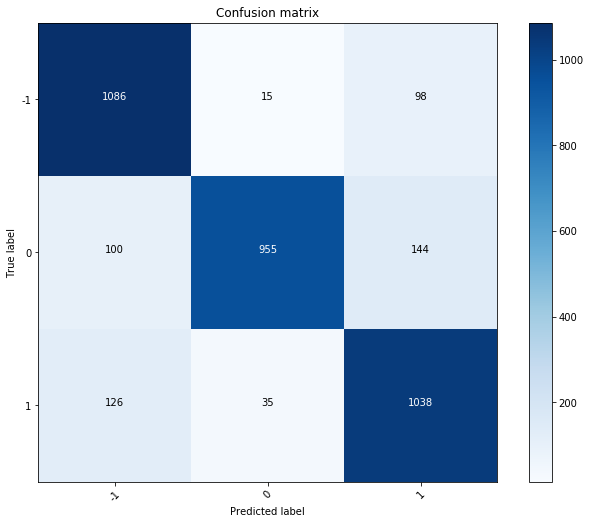

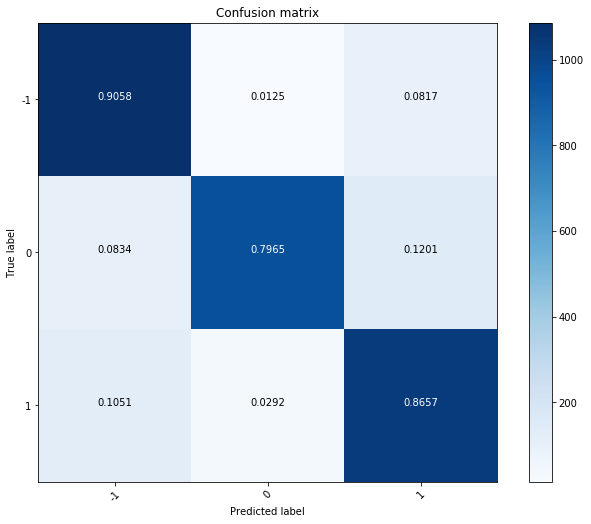

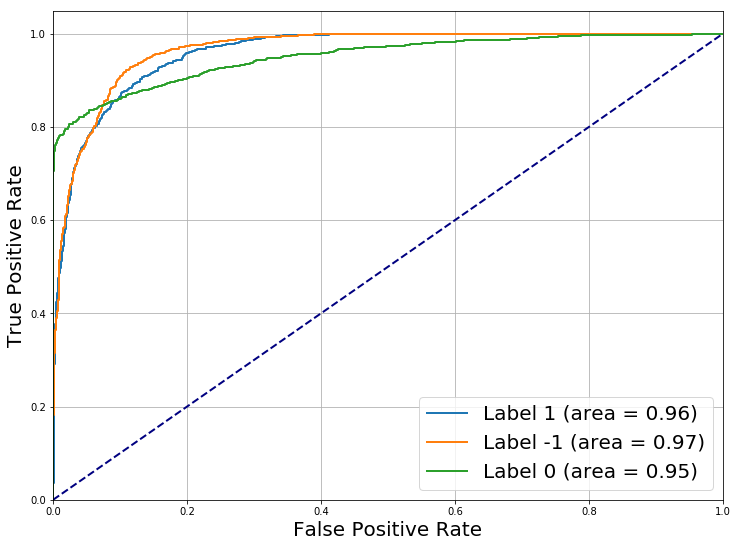

In [9]:
evaluator = MLEvaluator()
evaluator.set_pred_df(pred_df_train)
cf_mx_train = evaluator.generate_confusion_matrix()

fig = evaluator.plot_confusion_matrix(cf_mx_train.values, [-1, 0, 1])
fig = evaluator.plot_confusion_matrix(cf_mx_train.values, [-1, 0, 1], normalize=True)
fig = evaluator.plot_roc()

### Results on testing data

Confusion matrix, without normalization
[[  205    42    27]
 [17864 76601  7167]
 [   29    53   172]]
Normalized confusion matrix
[[0.74817518 0.15328467 0.09854015]
 [0.17577141 0.75370946 0.07051913]
 [0.11417323 0.20866142 0.67716535]]


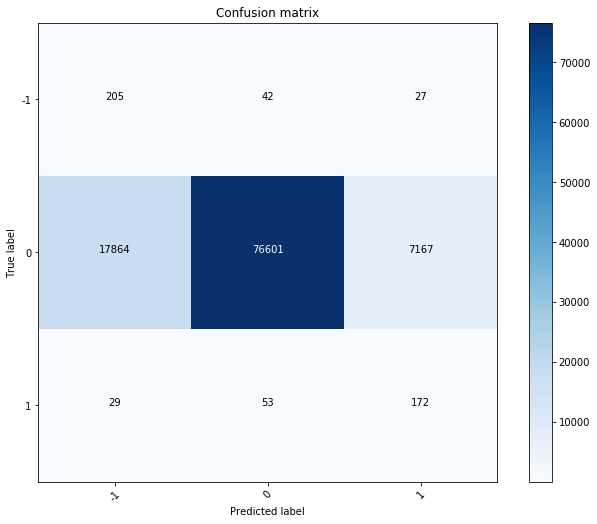

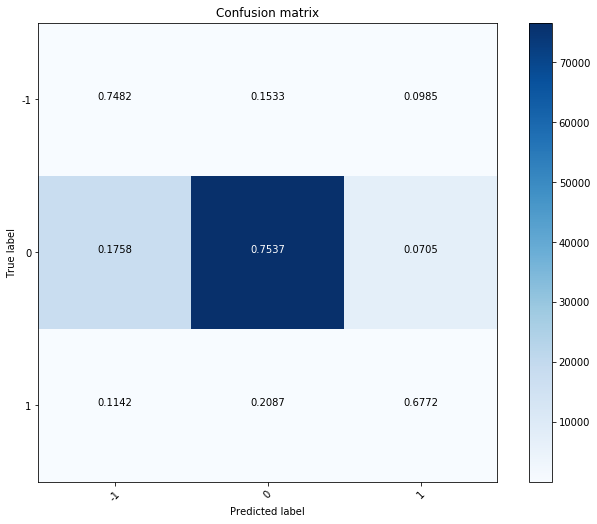

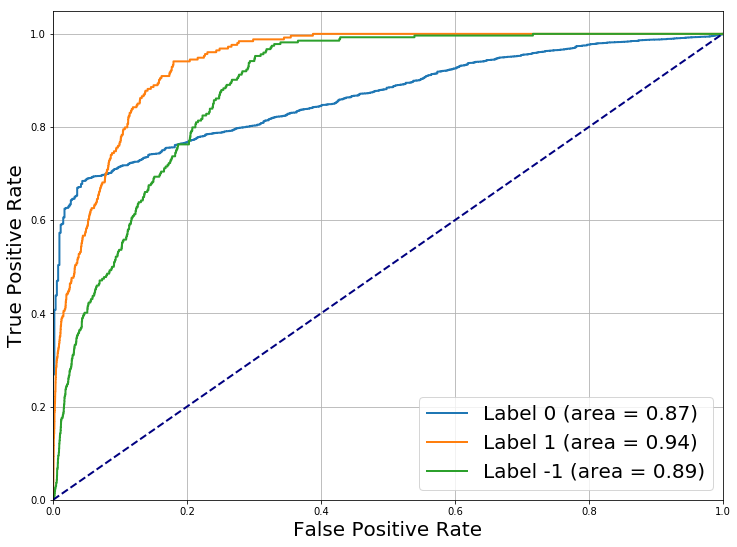

In [10]:
evaluator.set_pred_df(pred_df_test)
cf_mx_test = evaluator.generate_confusion_matrix()

fig = evaluator.plot_confusion_matrix(cf_mx_test.values, [-1, 0, 1])
fig = evaluator.plot_confusion_matrix(cf_mx_test.values, [-1, 0, 1], normalize=True)
fig = evaluator.plot_roc()